In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

# Part 1

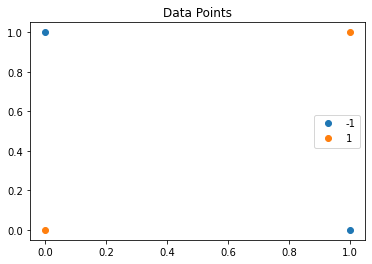

In [3]:
# a) Visualization


samples = pd.DataFrame({
    'x': [1, 0, 1, 0],
    'y': [1, 0, 0, 1],
    'label': [1, 1, -1, -1]
})
for name, group in samples.groupby('label'):
    plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

plt.title('Data Points')
plt.legend()



## b) Network implementation

I chose a two layer fully connected network with no hidden layers. I believe this is the simplest model that can still learn XOR. 

I am using relu as my activation function, and mean squared error loss.


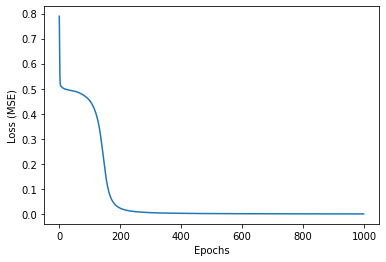

In [4]:


np.random.seed(43)

# activation functions
def relu(x):
    return max(0, x)
def d_relu(x):
    return max(0, min(x, 1))    
def tanh(x):
    return math.tanh(x)
def d_tanh(x):
    return 1 - tanh(x) ** 2
def loss(exp_y, act_y):
    return .5 * (exp_y - act_y) ** 2


# model
class Neuron:

    def __init__(self, activation_fn=relu):
        self.weights = np.random.rand(3)        
        self.activation_fn = activation_fn

    def pred(self, x, output_pre=False):
        pre_activation = self.weights @ self.concat(x)
        if output_pre:
            return pre_activation
        return self.activation_fn(pre_activation)
    
    def update(self, partials, lr):
        # print(partials)
        self.weights = self.weights - partials * lr
    
    @staticmethod
    def concat(x):
        return np.concatenate((x, [1]))


class NumpyModel:    
    def  __init__(self, lr=.1):
        self.input_layer = [Neuron(), Neuron()]
        self.output_layer = Neuron(activation_fn=tanh)
        self.lr = lr
    
    def pred(self, x, output_pre=False):
        return self.output_layer.pred([self.input_layer[0].pred(x), self.input_layer[1].pred(x)], output_pre=output_pre)
    
    def update(self, exp_y, act_y, x):
        # Update output neuron         
        il = self.input_layer
        partial_l_output_layer = (exp_y - act_y) * d_tanh(self.pred(x, output_pre=True)) * np.array([il[0].pred(x), il[1].pred(x), 1])

        # Update input neuron 
        def update_input_layer(index, neuron):                      
            pre = il[index].pred(x, output_pre=True)
            neuron.update((exp_y - act_y) * d_tanh(self.pred(x, output_pre=True)) * self.output_layer.weights[index] * d_relu(pre) * Neuron.concat(x), self.lr)

        update_input_layer(0, self.input_layer[0])
        update_input_layer(1, self.input_layer[1])      

        self.output_layer.update(partial_l_output_layer, self.lr)


  


# Train with stochastic gradient descent
def sgd(model, train_x, train_y):    
    y_preds = []


    for x, y in zip(train_x, train_y):        
        prediction = model.pred(x)      
        y_preds.append(prediction)
        
    # do the updates    
    for i in range(len(train_x)):
        model.update(y_preds[i], train_y[i], train_x[i])
            

def test(model, test_x, test_y, verbose=False):
    exp_y = [model.pred(x) for x in test_x]  
    if verbose:
        print('TEST X:', test_x)       
        print('TEST Y:', test_y)        
        print('PREDICTED Y:', exp_y)        
    return np.mean(loss(exp_y, test_y))


def train(model, train_x, train_y, epochs=10):
    history = []    
    for epoch in range(epochs):
        loss = test(model, train_x, train_y)
        history.append(loss)
        sgd(model, train_x, train_y)
    return history



train_x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

train_y = np.array([1, -1, -1, 1])
m = NumpyModel(.1)
history = train(m, train_x, train_y, epochs=1000)


plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.plot(history)

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9715215074907808, -0.9568908423303555, -0.9568043682265384, 0.9691123184751078]
LOSS: 0.0006861669356094473


TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9715215074907808, -0.9568908423303555, -0.9568043682265384, 0.9691123184751078]
LOSS: 0.0006861669356094473


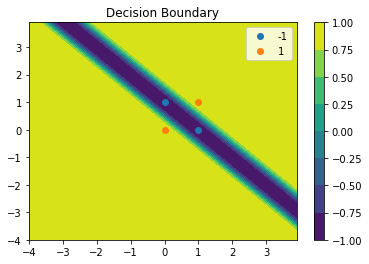

In [5]:
# c) Classification visualization 
# https://towardsdatascience.com/hands-on-guide-to-plotting-a-decision-surface-for-ml-in-python-149710ee2a0e

def model_visualize(train_x):    
    print('LOSS:', test(m, train_x, train_y, verbose=True))
    x1_scale = np.arange(-4, 4, 0.1)
    x2_scale = np.arange(-4, 4, 0.1)
    x_grid, y_grid = np.meshgrid(x1_scale, x2_scale)
    x_g, y_g = x_grid.flatten(), y_grid.flatten()
    x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
    grid = np.hstack((x_g, y_g))

    preds = []
    for val in grid:
        preds.append(m.pred(val))
    preds = np.array(preds).reshape(80, 80)

    surface = plt.contourf(x_grid, y_grid, preds)

    plt.colorbar(surface)

    samples = pd.DataFrame({
        'x': train_x[:, 0],
        'y': train_x[:, 1],
        'label': [1, -1, -1, 1]
    })    
    for name, group in samples.groupby('label'):
        plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

    plt.title('Decision Boundary')
    plt.legend()
    

model_visualize(train_x)

TEST X: [[ 0.24835708 -0.06913215]
 [ 0.32384427  0.76151493]
 [-0.11707669 -0.11706848]
 [ 0.78960641  0.38371736]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9316400632225872, -0.9628340682311238, -0.9246705889610745, 0.9999998750952726]
LOSS: 0.0014661134509934542


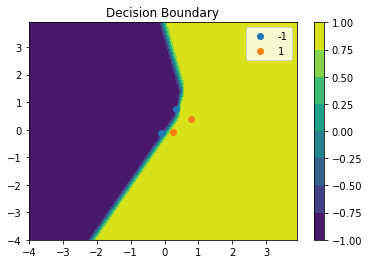

In [6]:
# d) Using random points

def train_and_visualize(sigma):
    np.random.seed(42)
    train_data = np.random.normal(loc=0.0, scale=sigma, size=train_x.shape)        
    train(m, train_data, train_y, epochs=1000)
    model_visualize(train_data)

train_and_visualize(.5)

TEST X: [[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]
 [ 1.57921282  0.76743473]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9988953522113394, -0.9911621975464242, -0.9895796414016577, 0.9999999999999986]
LOSS: 2.3488859032933772e-05


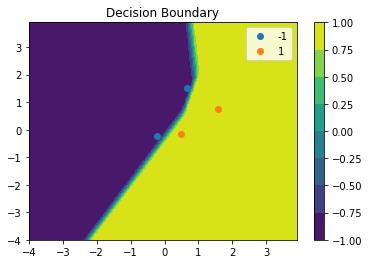

In [7]:
train_and_visualize(1)

TEST X: [[ 0.99342831 -0.2765286 ]
 [ 1.29537708  3.04605971]
 [-0.46830675 -0.46827391]
 [ 3.15842563  1.53486946]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9999999995248463, -0.9942824980830054, -0.9984965094405602, 1.0]
LOSS: 4.368789004145214e-06


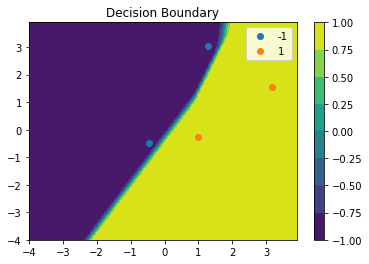

In [8]:
train_and_visualize(2)

# ADD COMMENTS ON THESE RESULTS

# Part 2

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

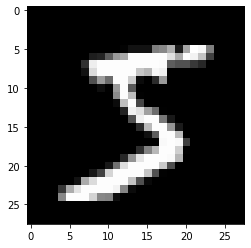

In [10]:
img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')

In [11]:
batch_size = 100
n_iters = 3000
# One iteration occurs after accumulating 100 (batch_size) gradients
# One epoch occurs after going through entire training set

num_epochs = n_iters / (len(train_dataset) / batch_size) # The number of iterations divided by amount of iterations in one epoch
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)                                    

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [13]:
input_dim = 28*28
output_dim = 10


model = LogisticRegressionModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  


In [14]:
def calc_accuracy(train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images to a Torch Variable
        images = images.view(-1, 28*28).requires_grad_()

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(lr): # make into train function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  
    accuracy = {'train': [], 'test': []} # keep track of accuracies

    for epoch in range(num_epochs):    
        for i, (images, labels) in enumerate(train_loader): # One epoch = 600 iterations or (train_dataset / batch_size)
            # This will load batch_size amount of samples

            # Load images as Variable
            images = images.view(-1, 28*28).requires_grad_()
            labels = labels
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy() # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)


Training with learning rate 1e-05
Epoch: 0 Loss: 2.327336072921753. Train Accuracy: 8.58666706085205, Test Accuracy: 7.329999923706055
Epoch: 1 Loss: 2.3207485675811768. Train Accuracy: 9.123332977294922, Test Accuracy: 7.869999885559082
Epoch: 2 Loss: 2.2992331981658936. Train Accuracy: 9.694999694824219, Test Accuracy: 8.449999809265137
Epoch: 3 Loss: 2.263629198074341. Train Accuracy: 10.331666946411133, Test Accuracy: 9.1899995803833
Epoch: 4 Loss: 2.267817974090576. Train Accuracy: 11.048333168029785, Test Accuracy: 10.010000228881836
Training with learning rate 0.0001
Epoch: 0 Loss: 2.245450019836426. Train Accuracy: 13.761666297912598, Test Accuracy: 14.399999618530273
Epoch: 1 Loss: 2.2235960960388184. Train Accuracy: 26.398332595825195, Test Accuracy: 27.65999984741211
Epoch: 2 Loss: 2.15198016166687. Train Accuracy: 39.25, Test Accuracy: 40.25
Epoch: 3 Loss: 2.105905771255493. Train Accuracy: 49.3466682434082, Test Accuracy: 49.380001068115234
Epoch: 4 Loss: 2.039616823196411

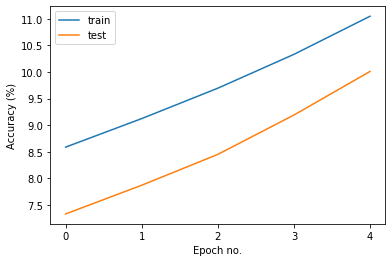

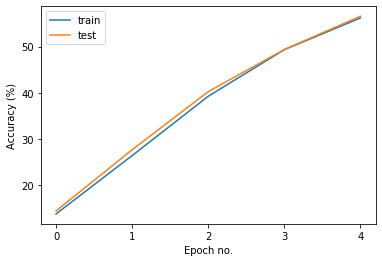

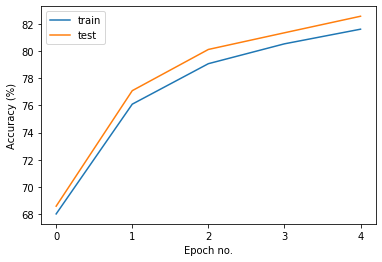

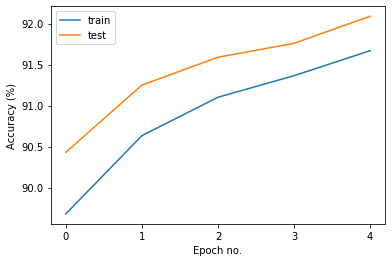

In [18]:
# a) Calculate training and test accuracy at the end of each epoch and the following learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.1]
for lr in learning_rates:
    model.linear.reset_parameters()
    print(f'Training with learning rate {lr}')
    history = train(lr)
    
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.gca().set_xticks(list(range(0, num_epochs)))

# Write your observation on training and test accuracy with respect to learning rate

<ipython-input-20-4336e33d2b61>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


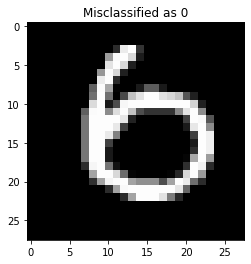

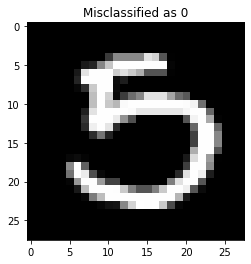

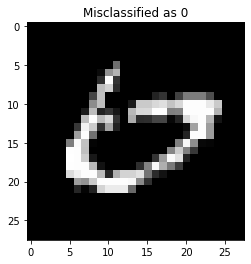

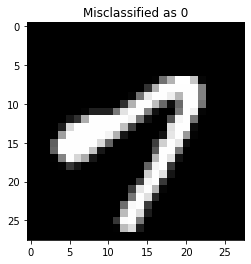

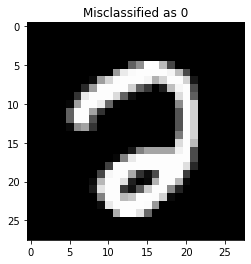

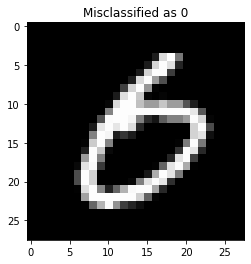

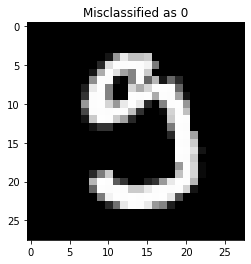

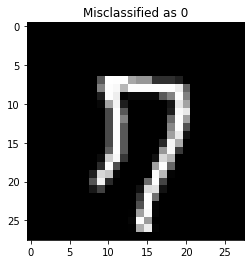

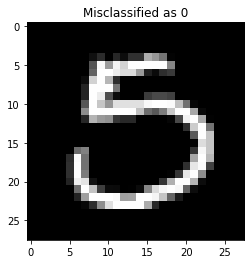

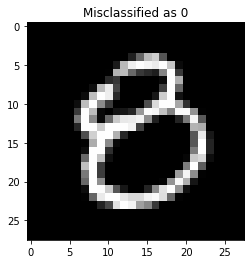

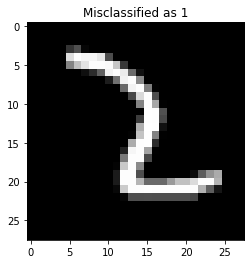

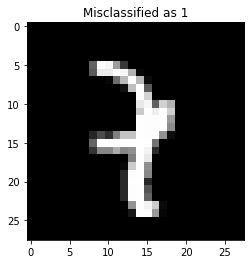

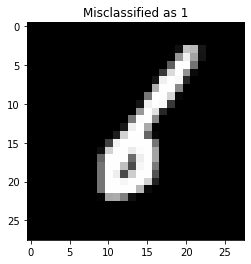

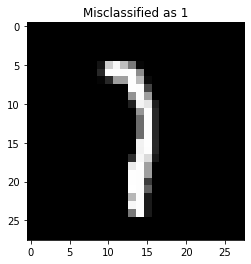

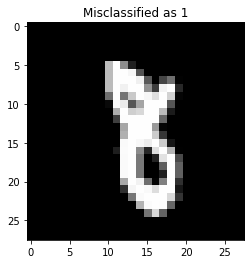

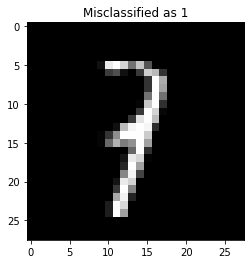

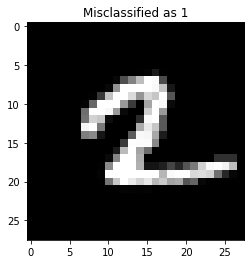

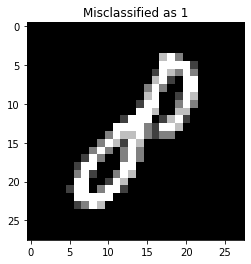

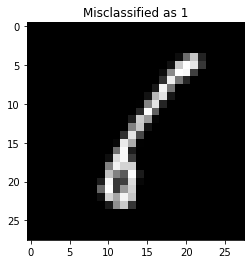

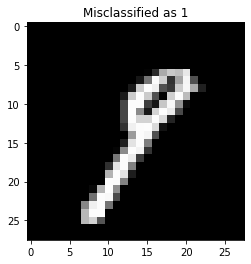

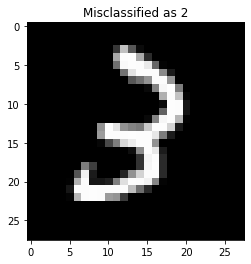

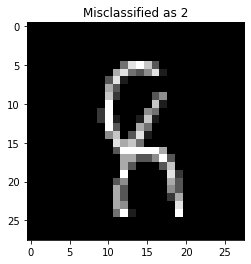

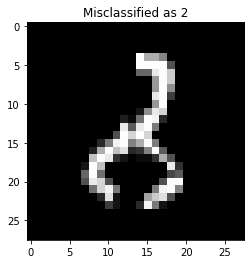

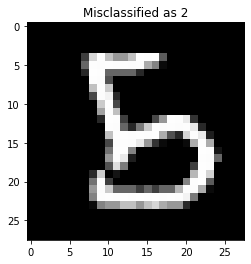

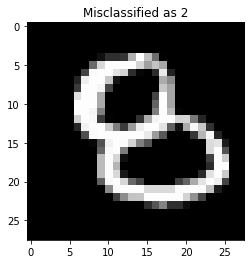

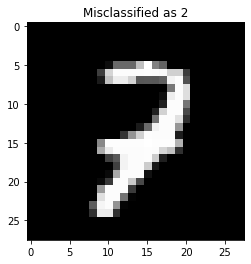

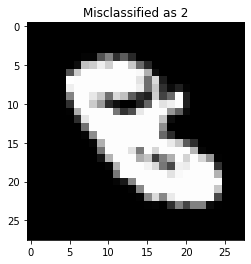

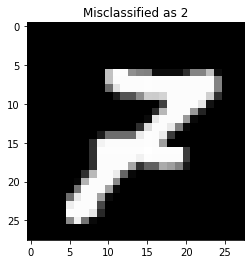

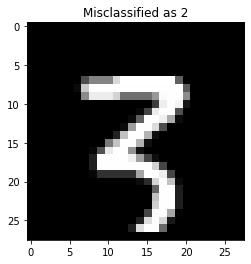

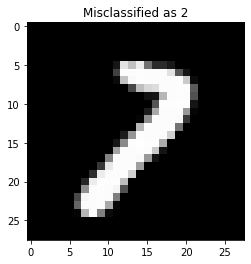

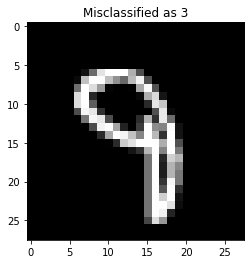

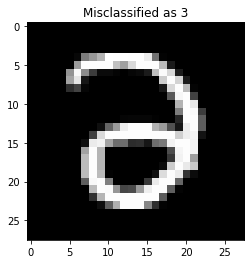

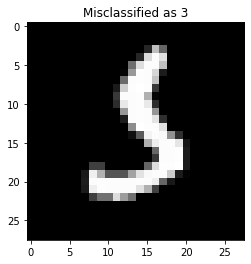

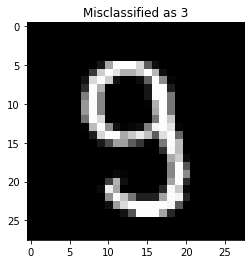

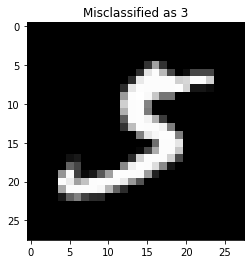

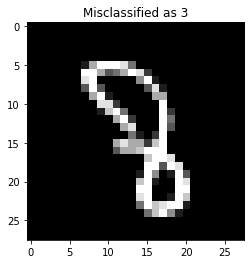

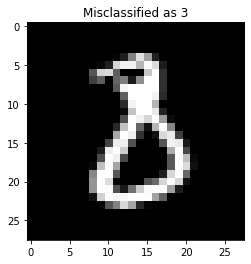

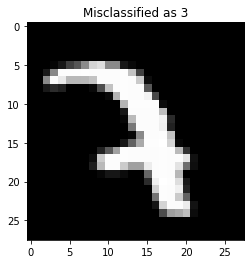

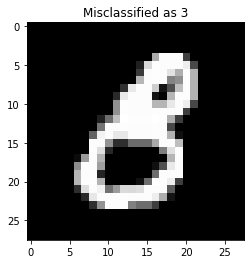

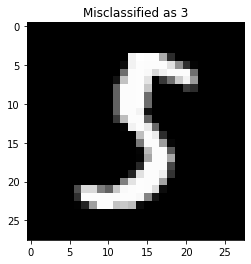

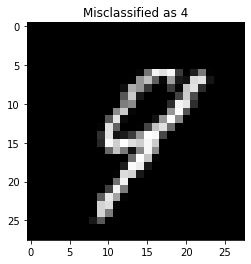

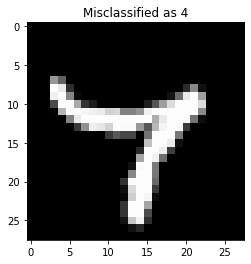

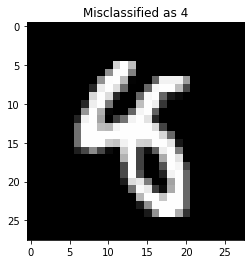

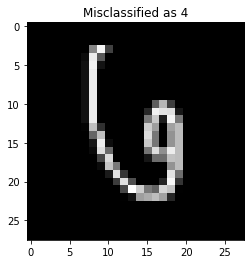

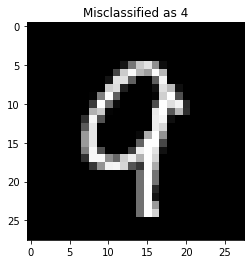

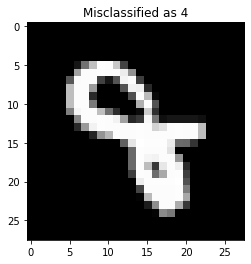

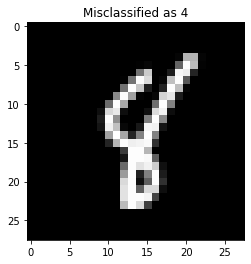

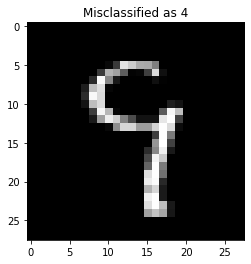

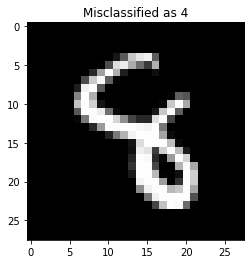

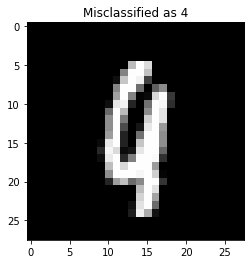

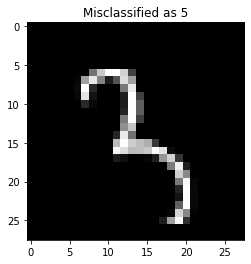

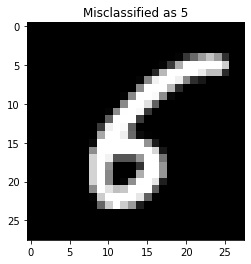

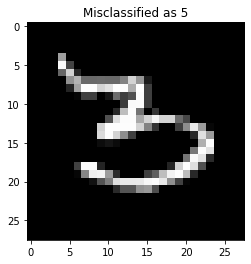

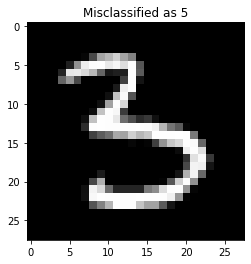

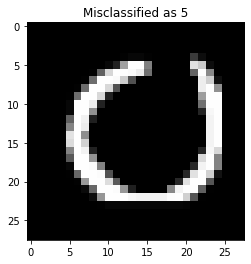

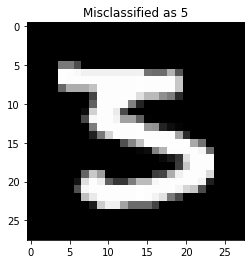

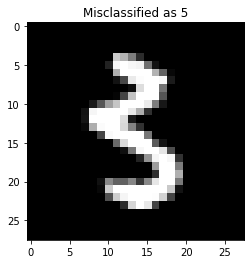

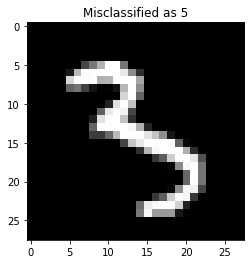

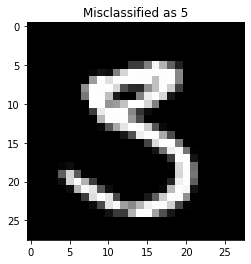

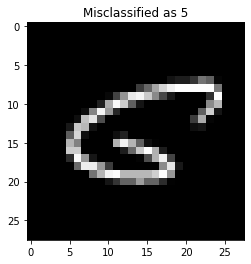

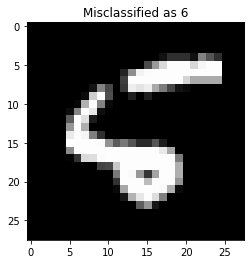

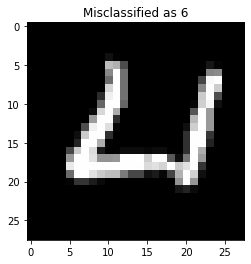

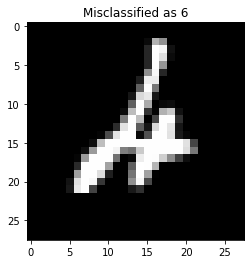

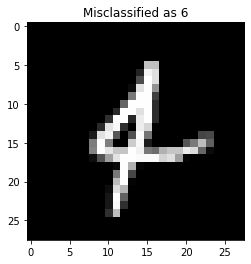

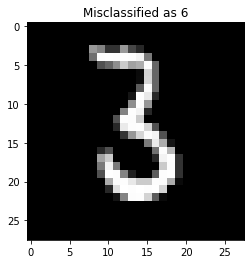

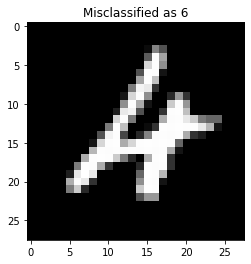

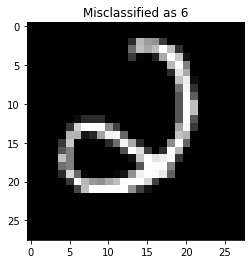

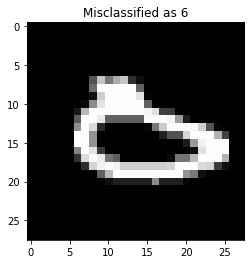

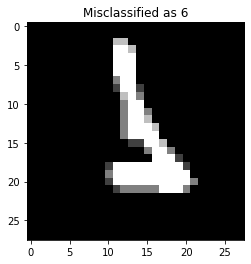

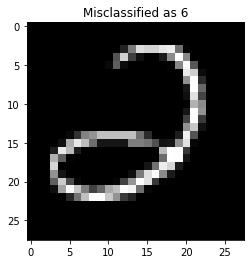

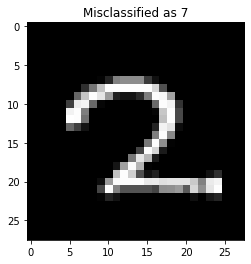

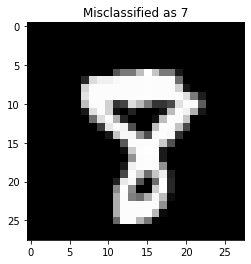

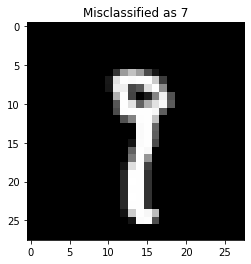

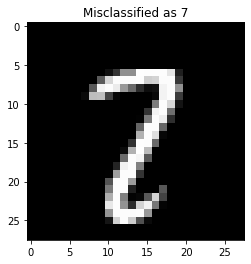

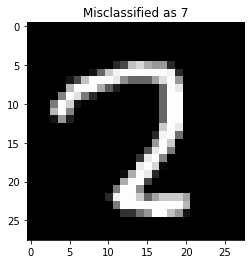

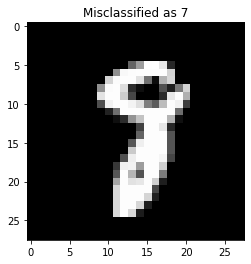

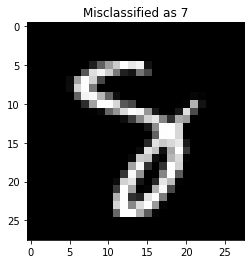

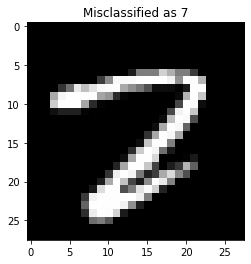

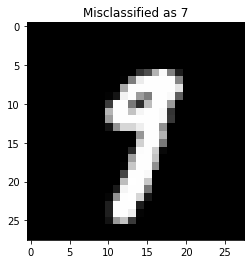

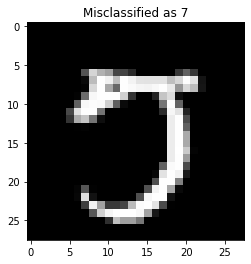

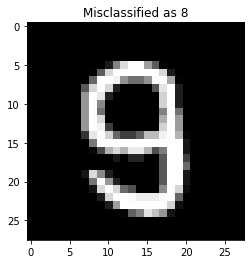

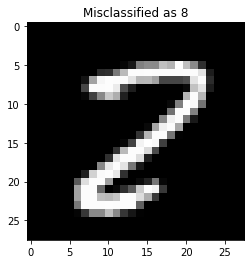

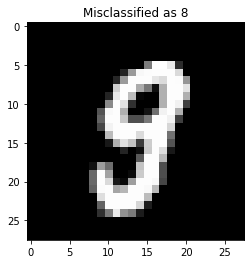

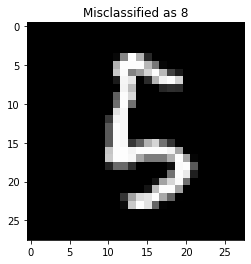

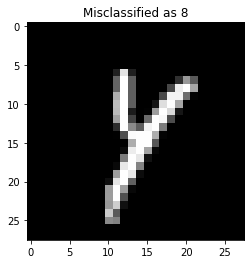

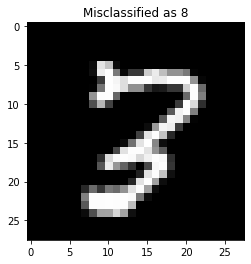

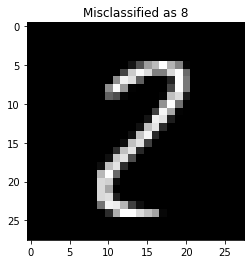

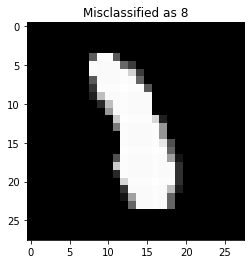

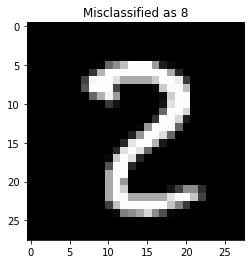

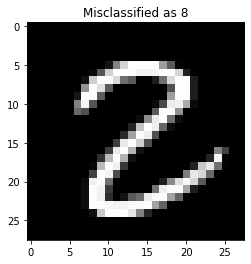

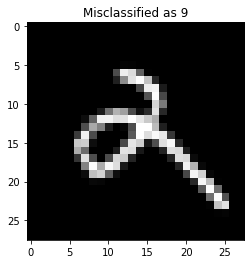

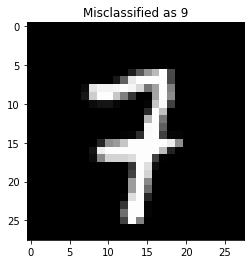

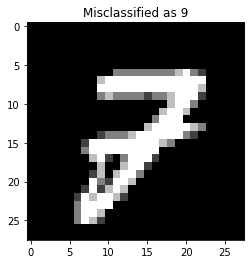

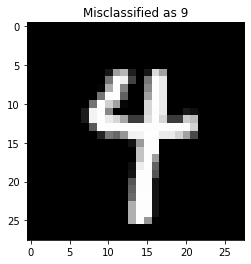

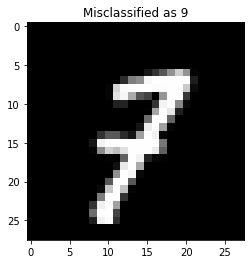

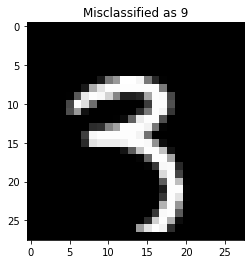

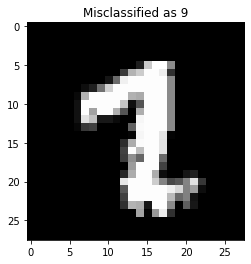

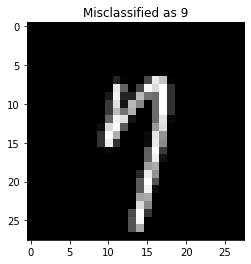

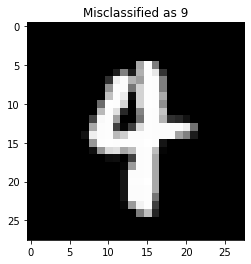

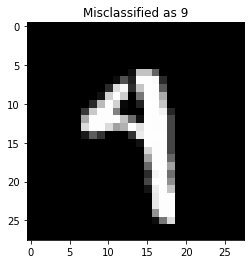

In [20]:
# b) Find 10 misclassified test samples for each output class

misclassified = {k: [] for k in range(10)}
incorrect = []
i = 0
for images, labels in test_loader:
    images = images.view(-1, 28*28)

    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)    
    for pred, act, image in zip(predicted, labels, images):
        if pred != act:
            misclassified[pred.item()].append(image) # save misclassified images




# wrong = 0
for clas in range(10):
    current_shown = 0
    for thing in misclassified[clas]:
        if current_shown == 10:
            break                
        plt.figure()
        plt.imshow(thing.numpy().reshape(28, 28), cmap='gray')
        plt.title(f"Misclassified as {clas}")
        current_shown += 1


# Explanation of misclassification

Epoch: 0 Loss: 0.3635214865207672. Train Accuracy: 85.70999908447266, Test Accuracy: 86.1500015258789
Epoch: 1 Loss: 0.44824454188346863. Train Accuracy: 86.68000030517578, Test Accuracy: 87.29000091552734
Epoch: 2 Loss: 0.3081117868423462. Train Accuracy: 87.27833557128906, Test Accuracy: 87.83000183105469
Epoch: 3 Loss: 0.3376266062259674. Train Accuracy: 87.58833312988281, Test Accuracy: 87.98999786376953
Epoch: 4 Loss: 0.2544919550418854. Train Accuracy: 87.88999938964844, Test Accuracy: 88.37000274658203


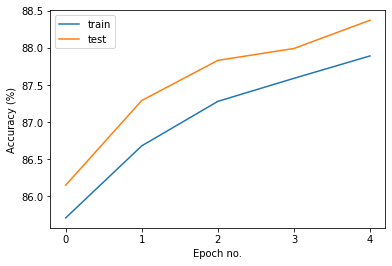

In [25]:

# c) Classify even-odd
from torchvision.transforms import Lambda

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1)
                            )
test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1))
input_dim = 28*28
output_dim = 2

model = LogisticRegressionModel(input_dim, output_dim)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)       
history = train(0.01)
history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
plt.gca().set_xticks(list(range(num_epochs)))

# Part 3: CNN

In [28]:
import torchvision
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

5.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

13.4%IOPub me

In [ ]:
trainloader